Epoch 0, Loss: 0.7859521508216858


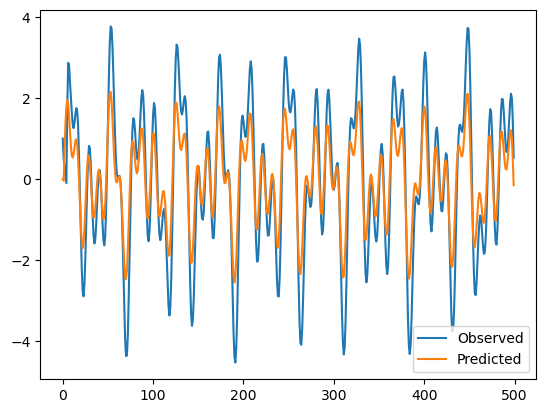

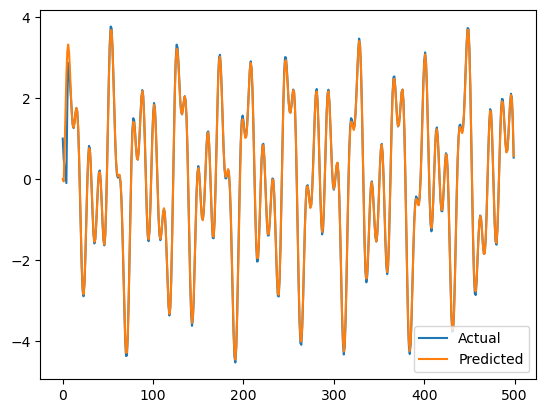

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate deterministic input signal (three incommensurate sinusoidal functions)
def generate_deterministic_input(L):
    freqs = 0.1 * torch.tensor([0.2534, 0.4112, 0.8321])
    t = torch.arange(L)
    u_k = torch.sin(2 * torch.pi * freqs[0] * t) + torch.sin(2 * torch.pi * freqs[1] * t) + torch.sin(2 * torch.pi * freqs[2] * t)
    return u_k

# Normalize the input signal to stabilize training
def normalize_input(u_k):
    return (u_k - u_k.mean()) / u_k.std()

# Generate AR(5) process with input and noise
def generate_ar5_with_noise(phi, B, Y_init, u_k, L, noise_std=0.01):
    y = torch.zeros(L)
    noise = torch.randn(L) * noise_std  # Additive Gaussian noise
    for i in range(5):
        y[i] = Y_init[i]
    for k in range(5, L):
        y[k] = sum(phi[j] * y[k - j - 1] for j in range(5)) + B * u_k[k - 1] + noise[k]
    return y

# Define an LSSM model for the AR(5) process with 7 hidden states
class LSSM_Model_AR7(nn.Module):
    def __init__(self):
        super(LSSM_Model_AR7, self).__init__()
        # Initialize parameters for LSSM (trainable parameters)
        self.A = nn.Parameter(torch.randn(7, 7) * 0.05)  # 7x7 matrix for A (trainable)
        self.x0 = nn.Parameter(torch.randn(7) * 0.05)  # Initial hidden state (7x1) (trainable)

        # Fixed B, C, and D (non-trainable)
        self.register_buffer('B', torch.zeros(7, 1))  # 7x1 matrix for B (fixed)
        self.B[0, 0] = 1.0  # Only the first entry is 1, the rest are 0
        self.register_buffer('C', torch.zeros(1, 7))  # 1x7 matrix for C (fixed)
        self.C[0, 0] = 1.0  # Only the first entry is 1, the rest are 0
        self.register_buffer('D', torch.tensor(0.0))  # Scalar D = 0 (fixed)

    def forward(self, u_k, L):
        x = torch.zeros((L, 7))  # 7 hidden states
        y_pred = torch.zeros(L)
        x[0] = self.x0.clone()  # Clone to avoid in-place modification

        # Avoid in-place operations during forward pass
        for k in range(1, L):
            x[k] = torch.matmul(self.A, x[k-1].clone()) + torch.matmul(self.B, u_k[k-1].unsqueeze(0)).clone()
            y_pred[k] = torch.matmul(self.C, x[k].clone()) + self.D * u_k[k]

        return y_pred

# Training the model using BPTT
def train_model(y_observed, u_k, epochs=100, learning_rate=0.01):
    L = len(y_observed)
    model = LSSM_Model_AR7()
    optimizer = optim.SGD([model.A, model.x0], lr=learning_rate)  # Only train A and x0
    loss_fn = nn.MSELoss()

    y_observed_tensor = y_observed.clone().detach().requires_grad_(False)  # Fix warning
    u_k_tensor = u_k.clone().detach().requires_grad_(False)  # Fix warning

    for epoch in range(epochs):
        optimizer.zero_grad()  # Clear gradients
        y_pred = model(u_k_tensor, L)  # Forward pass
        loss = loss_fn(y_pred, y_observed_tensor)  # Loss computation
        loss.backward()  # Backward pass (compute gradients)

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_([model.A, model.x0], max_norm=1.0)

        optimizer.step()  # Parameter update

        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            plt.plot(y_observed, label='Observed')
            plt.plot(y_pred.detach().numpy(), label='Predicted')
            plt.legend()
            plt.show()

    return model

# Generate input signal and AR(5) process with noise
L = 500  # Set the length of the time series to 500
u_k = generate_deterministic_input(L)
u_k = normalize_input(u_k)

# True AR(5) parameters
phi_true = [0.6, -0.2, 0.1, 0.05, -0.05]
B_true = 1.0
Y_init = [1.0, 0.5, 0.3, 0.1, -0.1]  # Initial conditions for AR(5)
y_noisy = generate_ar5_with_noise(phi_true, B_true, Y_init, u_k, L, noise_std=0.01)

# Enable anomaly detection for better error tracing
torch.autograd.set_detect_anomaly(True)

# Train the model
model = train_model(y_noisy, u_k, epochs=100, learning_rate=0.01)

# Compare predicted vs actual output
def compare_model_output(model, u_k, y_actual):
    L = len(y_actual)
    u_k_tensor = u_k.clone().detach().requires_grad_(False)
    y_pred = model(u_k_tensor, L).detach().numpy()

    plt.plot(y_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

compare_model_output(model, u_k, y_noisy)